# 0. 들어가기 전에 - 핵심 요약
- 코로나 바이러스 확진자/완치자/사망자 관련 추이를 다룰 때, 주로 전국 합산된 통계가 많이 사용됩니다. 그러나 잘 알려져 있듯이 한국의 대다수 확진자/사망자는 대구와 경북 지역에서 발생했기 때문에, <span style="color:red">전국의 추이는 곧 대구와 경북의 추이</span> 라고 할 수 있습니다. 이로 인해 그 외 지역의 추이는 전국 추이에서 가려져 인식되지 못할 수 있습니다.
<br>
- 그래서 코로나 바이러스 관련 데이터를 지역별로 나누어 분석하면 어떨지 궁금했습니다. 특히 <span style="color:red">지역별로 인구 구성, 의료 인프라 등의 요인이 달라질 때 코로나 완치 속도가 어떻게 달라지는지</span> 살펴보고자 했습니다.
<br><br>
- 본 분석 결과에 따르면, 각 지역의 <span style="color:red">'감염병 전담병원 수(병상 수)'</span>가 <span style="color:red">코로나 바이러스 극복 속도</span>에 영향을 주는 것으로 보입니다. 기본적으로 코로나 바이러스 완치자 증가 속도는 해당 지역의 확진자 증가 속도에 영향을 받지만, 감염병 전담시설 확충 정도가 추가적인 영향을 준다고 짐작할 수 있는 대목입니다.

## 실행 환경 : 캐글 노트북
<hr>
## 사용 데이터
- Time.csv : 대한민국 전체의 시계열 데이터 (출처 : 대회 제공 데이터)
- TimeProvince.csv : 대한민국 지역별 시계열 데이터 (출처 : 대회 제공 데이터)
- Region_sido_addPop_addHospital.csv : 대회에서 제공된 Region.csv에서 시/도 단위만 추출해 인구수(2020년 3월 기준), 국민안심병원 수, 감염병전담병원 수 추가 (데이터 출처 : 행정안전부 주민등록 인구통계, 보건복지부 국민안심병원 현황, 보건복지부 감염병전담병원 관련 보도자료)
- PatientInfo.csv : 대한민국 환자 개인별 데이터 (출처 : 대회 제공 데이터)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta

import warnings
warnings.filterwarnings("ignore")

# 나눔체 글꼴 설치 (matplotlib 한글폰트 깨지는 현상 해결)
import matplotlib.font_manager as fm
!apt-get update -qq
!apt-get install fonts-nanum* -qq

font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
font_prop_size20 = fm.FontProperties(fname=font_path, size=20)
font_prop_size15 = fm.FontProperties(fname=font_path, size=15)
font_prop_size10 = fm.FontProperties(fname=font_path, size=10)




# 캐글 이외의 가상 노트북 환경에서 데이터 로드 방법
# !git clone https://github.com/jihoo-kim/Data-Science-for-COVID-19.git
# data_path = './Data-Science-for-COVID-19/dataset/'

Time_df = pd.read_csv('../input/coronavirusdataset/Time.csv')
TimeProvince_df = pd.read_csv('../input/coronavirusdataset/TimeProvince.csv')
Region_df = pd.read_csv('../input/coronavirusdatasetmodified/Region_sido_addPop_addHospital.csv')

PatientInfo_df = pd.read_csv('../input/coronavirusdataset/PatientInfo.csv')

Case_df = pd.read_csv('../input/coronavirusdataset/Case.csv')

debconf: delaying package configuration, since apt-utils is not installed
Selecting previously unselected package fonts-nanum.
(Reading database ... 72030 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20140930-1_all.deb ...
Unpacking fonts-nanum (20140930-1) ...
Selecting previously unselected package fonts-nanum-eco.
Preparing to unpack .../fonts-nanum-eco_1.000-6_all.deb ...
Unpacking fonts-nanum-eco (1.000-6) ...
Selecting previously unselected package fonts-nanum-extra.
Preparing to unpack .../fonts-nanum-extra_20140930-1_all.deb ...
Unpacking fonts-nanum-extra (20140930-1) ...
Selecting previously unselected package fonts-nanum-coding.
Preparing to unpack .../fonts-nanum-coding_2.0-10_all.deb ...
Unpacking fonts-nanum-coding (2.0-10) ...
Setting up fonts-nanum-extra (20140930-1) ...
Setting up fonts-nanum (20140930-1) ...
Setting up fonts-nanum-coding (2.0-10) ...
Setting up fonts-nanum-eco (1.000-6) ...
Processing triggers for fontconfig (2.11.0-

## 1. 전국 코로나 바이러스 확진자/완치자 추이 시각화

- 우선, 전체적인 경향을 확인하기 위해 코로나 바이러스의 전국 추이를 살펴보겠습니다.

In [2]:
# Time_df 데이터 전처리 - 파생변수 생성 : new_comfirmed(일일 확진자 수), new_released(일일 완치자 수), new_deceased(일일 사망자 수)
Time_df['date'] = pd.to_datetime(Time_df['date'])

tmp_df = Time_df[['date','confirmed', 'released', 'deceased']].rename(columns={'confirmed':'confirmed_D-1', 'released':'released_D-1', 'deceased':'deceased_D-1'})
tmp_df['date'] = tmp_df['date'] + timedelta(days=1)
Time_df = pd.merge(Time_df, tmp_df, how='left', on=['date'])
del tmp_df

Time_df[['confirmed_D-1', 'released_D-1', 'deceased_D-1']] = Time_df[['confirmed_D-1', 'released_D-1', 'deceased_D-1']].fillna(0).astype(int)
Time_df['new_confirmed'] = Time_df['confirmed'] - Time_df['confirmed_D-1']
Time_df['new_released'] = Time_df['released'] - Time_df['released_D-1']
Time_df['new_deceased'] = Time_df['deceased'] - Time_df['deceased_D-1']
Time_df = Time_df.drop(columns=['time', 'test', 'negative', 'confirmed_D-1', 'released_D-1', 'deceased_D-1'])


# Time_df 데이터 전처리 - 파생변수 생성 : active(격리된 환자 수) = confirmed - deceased - released
Time_df['active'] = Time_df.confirmed - Time_df.released - Time_df.deceased


# 가장 최근 날짜의 전국 현황 추출
recent_korea = Time_df.loc[len(Time_df)-1]

# 2020년 3월 기준 대한민국 인구 추출 (출처 : 행정안전부 주민등록 인구통계) - Region_df
pop_korean = int(Region_df.loc[Region_df.province=='Korea', 'pop_total'])

(2020년 05월 14일 기준)
전국 누적 확진자 : 10991 명 (인구 대비 확진자 비율 : 0.02%)
전국 누적 완치자 :  9762 명 (완치율 : 88.82%)
전국 치료중 환자 :   969 명


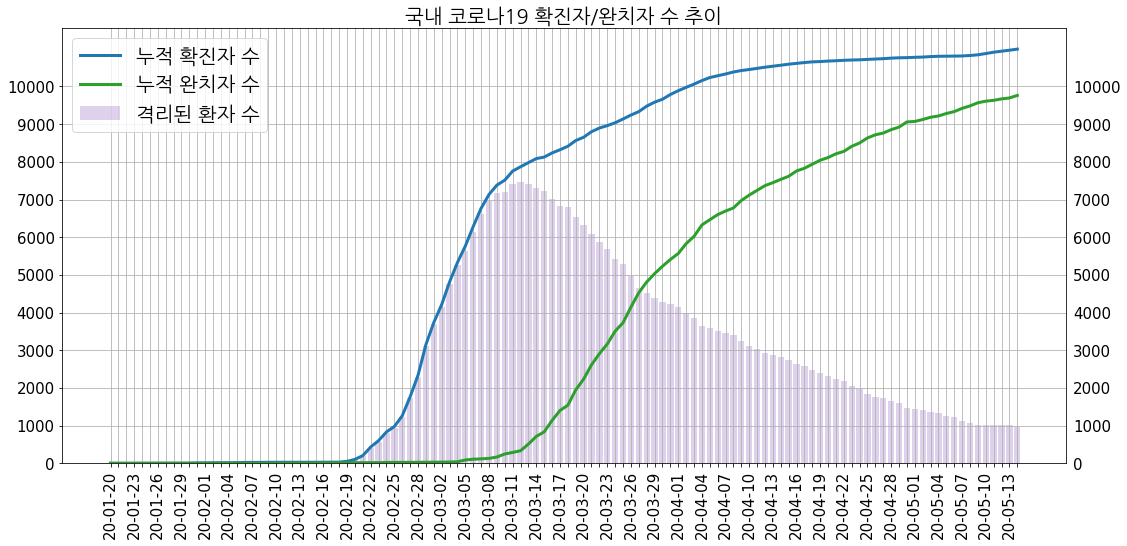

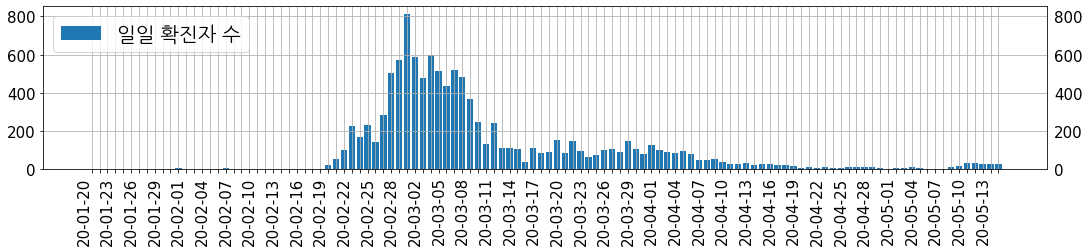

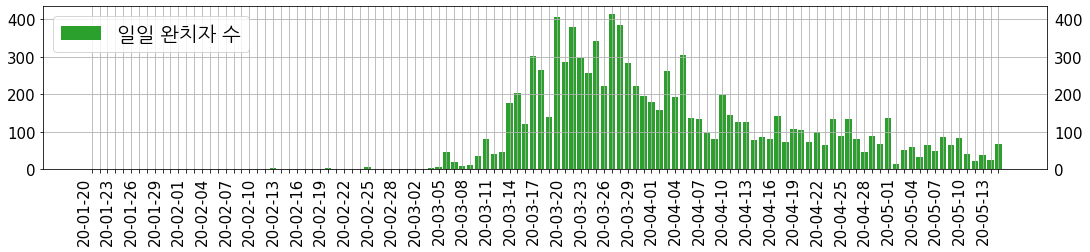

In [3]:
# 최근 날짜의 현황 출력
print(f'({recent_korea.date.strftime("%Y년 %m월 %d일")} 기준)')
print(f'전국 누적 확진자 : {recent_korea.confirmed:>5} 명 '+
      f'(인구 대비 확진자 비율 : {recent_korea.confirmed/pop_korean*100:.2f}%)')
print(f'전국 누적 완치자 : {recent_korea.released:>5} 명 '+
      f'(완치율 : {recent_korea.released/recent_korea.confirmed*100:.2f}%)')
print(f'전국 치료중 환자 : {recent_korea.active:>5} 명')


## 그래프1 - 누적 확진자/완치자 수 추이
plt.figure(figsize=(18,8))
plt.plot( Time_df.date, Time_df.confirmed, 'tab:blue', linewidth=3, label='누적 확진자 수' )
plt.plot( Time_df.date, Time_df.released, 'tab:green', linewidth=3, label='누적 완치자 수' )
plt.bar( Time_df.date, Time_df.active, color='tab:purple', alpha=0.3, label='격리된 환자 수' )

plt.title('국내 코로나19 확진자/완치자 수 추이', fontproperties=font_prop_size20)
plt.xticks( ticks=Time_df.date,
            labels=[ date[2:] if idx%3==0 else '' for idx, date in enumerate(Time_df.date.astype(str)) ],
            rotation=90, size=15)
plt.yticks( ticks=range(0, 11000, 1000) )
plt.tick_params(axis='y', which='both', labelleft='off', labelright='on', labelsize=15)
plt.legend(prop=font_prop_size20, loc='upper left')
plt.grid()


## 그래프2 - 일일 확진자, 사망자, 완치자 수
def daily_barplot( x=Time_df.date, y=Time_df.new_confirmed, color='tab:red', label='일일 확진자 수' ):
    plt.figure(figsize=(18,3))
    plt.bar( x, y, color=color, label=label )
    plt.xticks( ticks=Time_df.date,
                labels=[ date[2:] if idx%3==0 else '' for idx, date in enumerate(Time_df.date.astype(str)) ],
                rotation=90, horizontalalignment='right', size=15)
    plt.tick_params(axis='y', which='both', labelleft='off', labelright='on', labelsize=15)
    plt.legend(prop=font_prop_size20, loc='upper left')
    plt.grid()
    plt.show()
    pass

daily_barplot( x=Time_df.date, y=Time_df.new_confirmed, color='tab:blue', label='일일 확진자 수' )
daily_barplot( Time_df.date, Time_df.new_released, color='tab:green', label='일일 완치자 수' )

- 전국적으로 2월 하순(23일)~3월 중순(12일) 사이에 확진자 수가 폭증했습니다. 그리고 확진자 증가세가 꺾인 3월 중순(12일)~4월 중순(10일) 사이에 완치자 수가 눈에 띄게 증가했습니다. 이에 따라, 지속적으로 상승하던 격리 환자 수는 3월 12일을 기점으로 뚜렷한 하락세를 이어오고 있습니다.
<br><br><br>
- 그러나 본 그래프는 전국의 데이터를 한 데 모아 시각화한 것입니다. 특히 아래 테이블에서 확인할 수 있는 것처럼 대구/경북이라는 일부 지역의 감염사례가 압도적으로 많은 비중(약 80%)을 차지하기 때문에, 전혀 다르게 움직이는 타 지역의 양상을 가려버렸을 수 있습니다. 이에 좀 더 깊게 들어가 지역별로 세분화한 분석을 수행하겠습니다.

In [4]:
recent_df = TimeProvince_df[TimeProvince_df.date == TimeProvince_df.date.max()]

tmp_df = pd.merge(recent_df, Region_df, how='left', on='province').loc[:, ['date', 'province_kor', 'released', 'deceased', 'confirmed', 'pop_total']]
tmp_df['confirmed_ratio_in_totalcase'] = tmp_df['confirmed'] / tmp_df['confirmed'].sum() * 100
tmp_df['confirmed_ratio_in_population'] = tmp_df['confirmed'] / tmp_df['pop_total'] * 1000000

tmp_df[['confirmed_ratio_in_totalcase', 'confirmed_ratio_in_population']] = tmp_df[['confirmed_ratio_in_totalcase', 'confirmed_ratio_in_population']].applymap(lambda x : round(x, 3))
tmp_df = tmp_df.drop(columns=['pop_total']).sort_values('confirmed_ratio_in_population', ascending=False).reset_index(drop=True)

tmp_df.columns = ['기준일', '지역(시/도)', '누적완치자', '누적사망자', '누적확진자', '누적확진자 비중(전국 대비, %)', '누적확진자(인구100만명당)']

print(f'({recent_korea.date.strftime("%Y년 %m월 %d일")} 기준)')
print(f'전국 누적 확진자 : {recent_korea.confirmed:>5} 명')
tmp_df.style.background_gradient(cmap="Blues", subset=['누적확진자']).\
             background_gradient(cmap="Purples", subset=['누적확진자 비중(전국 대비, %)'])

(2020년 05월 14일 기준)
전국 누적 확진자 : 10991 명


,기준일,지역(시/도),누적완치자,누적사망자,누적확진자,"누적확진자 비중(전국 대비, %)",누적확진자(인구100만명당)
0,2020-05-14,대구광역시,6349,179,6865,65.319,2820.96
1,2020-05-14,경상북도,1237,54,1368,13.016,515.561
2,2020-05-14,세종특별자치시,46,0,47,0.447,136.314
3,2020-05-14,서울특별시,564,4,711,6.765,73.046
4,2020-05-14,충청남도,138,0,144,1.37,67.933
5,2020-05-14,경기도,577,16,714,6.794,53.729
6,2020-05-14,부산광역시,127,3,144,1.37,42.23
7,2020-05-14,인천광역시,85,0,119,1.132,40.302
8,2020-05-14,울산광역시,41,1,45,0.428,39.316
9,2020-05-14,강원도,43,2,55,0.523,35.747


## 2. 지역별 코로나 바이러스 확진자/완치자 추이 시각화 (13개 시/도)

- 우선, 앞서 전국 단위로 보았던 것과 동일한 그래프를 지역별로 그려보겠습니다. 각 지역별 코로나 바이러스 확진자/완치자 추이가 조금씩 다른 것을 볼 수 있습니다.
- 호남(전북, 전남, 광주)과 제주 권역 4개 시/도의 경우, 추이를 보기에는 상대적으로 확진자 수가 너무 적어 제외했습니다.

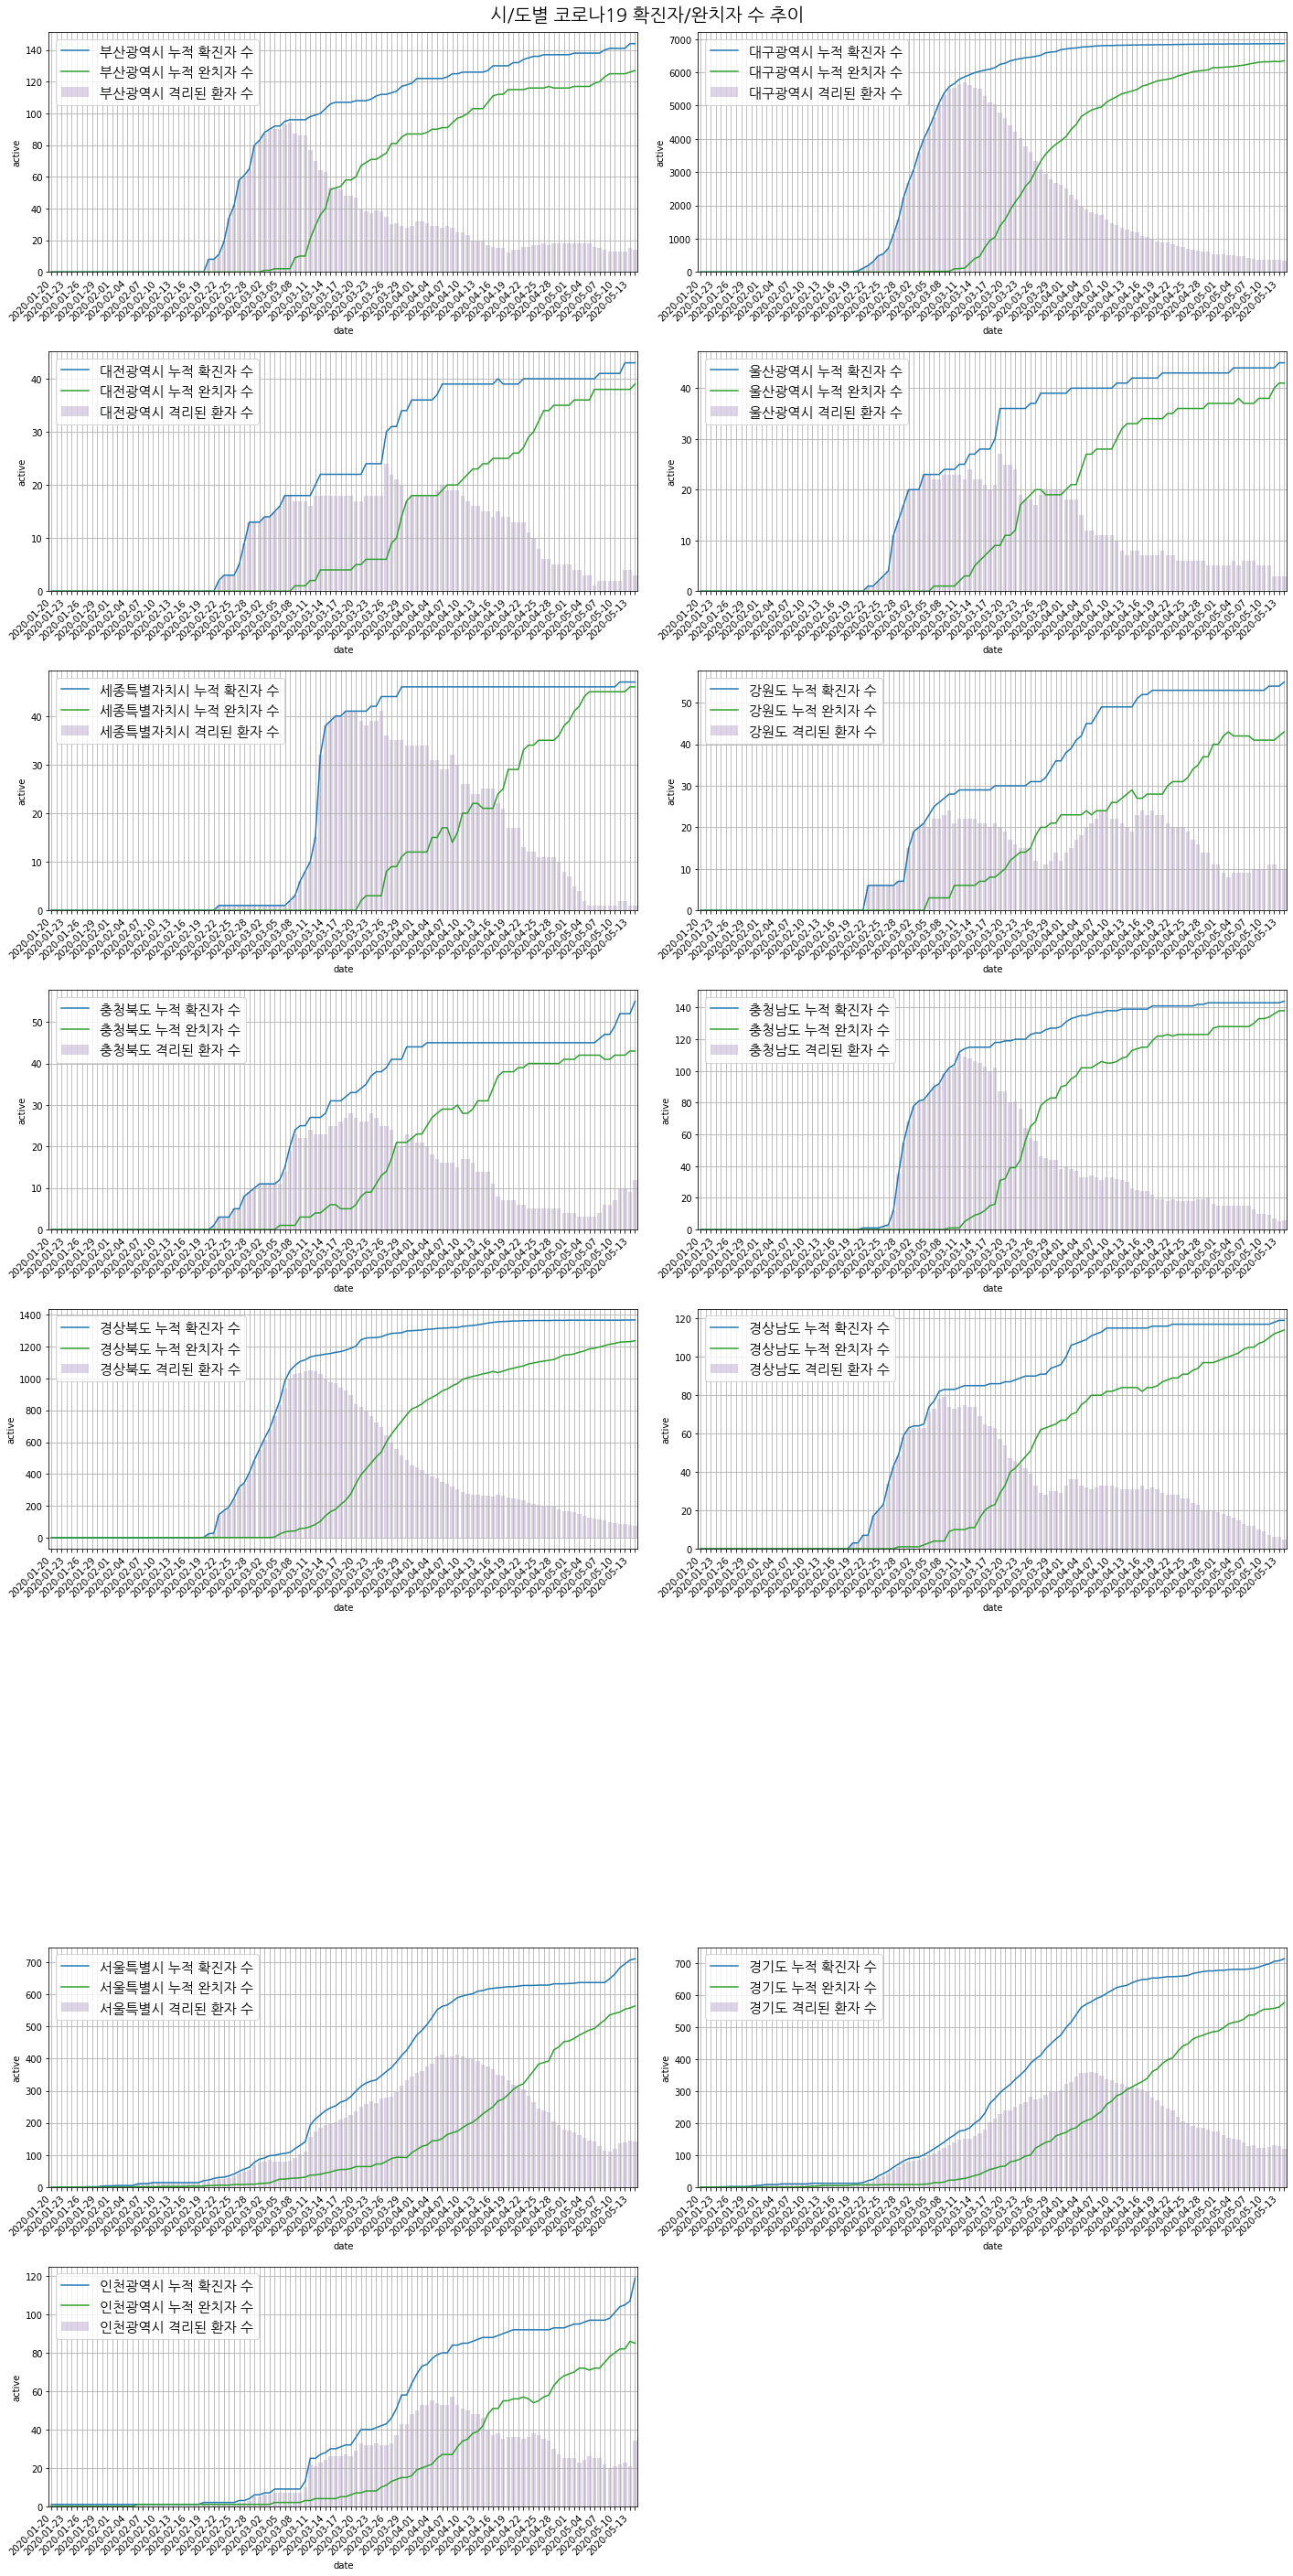

In [5]:
TimeProvince_df_kor = pd.merge(TimeProvince_df, Region_df, how='left', on='province').loc[:, ['date', 'province_kor', 'confirmed', 'released', 'deceased']]
TimeProvince_df_kor = TimeProvince_df_kor[~TimeProvince_df_kor.province_kor.isin(['전라북도', '전라남도', '광주광역시', '제주특별자치도'])]  # 4개 시/도 제외

TimeProvince_df_kor['active'] = TimeProvince_df_kor['confirmed'] - TimeProvince_df_kor['deceased'] - TimeProvince_df_kor['released']
cities = ['부산광역시', '대구광역시', '대전광역시', '울산광역시', '세종특별자치시', '강원도', '충청북도', '충청남도', '경상북도', '경상남도',
          '서울특별시', '경기도', '인천광역시']

nrows = len(cities)//2+2
fig = plt.figure(figsize=(20, 5*nrows))
plt.suptitle('시/도별 코로나19 확진자/완치자 수 추이', fontproperties=font_prop_size20)

for idx, city in enumerate(cities):
    if city in ['서울특별시', '경기도', '인천광역시']:  # 수도권 plot 두 칸 미루기(공백 한 줄 만들기)
        idx += 2
    
    tmp_ax = plt.subplot(nrows, 2, idx+1)
    tmp_df = TimeProvince_df_kor[TimeProvince_df_kor.province_kor==city]
    
    sns.lineplot(tmp_df.date, tmp_df.confirmed, color='tab:blue', label=f'{city} 누적 확진자 수', ax=tmp_ax)
    sns.lineplot(tmp_df.date, tmp_df.released, color='tab:green', label=f'{city} 누적 완치자 수', ax=tmp_ax)
    sns.barplot(tmp_df.date, tmp_df.active, color='tab:purple', alpha=0.3, label=f'{city} 격리된 환자 수', ax=tmp_ax)
    
    plt.xticks(tmp_df.date, rotation=45, horizontalalignment='right')
    tmp_xticks_labels = [ date if idx%3==0 else '' for idx, date in enumerate(tmp_df.date) ]
    tmp_ax.set_xticklabels(tmp_xticks_labels)
    
    tmp_ax.legend(prop=fm.FontProperties(fname=font_path, size=15))
    plt.grid()
    pass

plt.tight_layout(pad=2)
plt.subplots_adjust(top=0.97)

plt.show()

- 이상의 그래프에서 지역별 추이를 살펴보니, 크게 두 가지로 경향이 나뉘는 것으로 보입니다.
- 위쪽 열 개의 비수도권 그래프에서는 전국 그래프와 유사한 경향이 보입니다. 즉, 초반 확진자가 폭증하다가 증가세가 꺾이는 시점에 맞춰 완치자가 증가하기 시작합니다.
- 반면 아래쪽 세 개의 수도권(서울,경기,인천) 지역 그래프에서는 사뭇 다른 경향이 보입니다. 대체로 그래프가 완만하게 증가하고, 완치자 역시 유사하게 완만한 증가세를 보입니다.
<br><br>
- 이상의 내용을 한눈에 살펴보기 위해, 아래에서 "각 시/도별 첫 번째 확진자 발생 이후 누적확진자/완치자 추이"를 시각화함으로써 하나의 그래프에 담았습니다. 시/도별 첫 확진자 발생 시점이 다르기 때문에, x축을 "첫 번째 확진자 발생 이후의 일수"로 바꾸어 출발점을 통일시켰습니다.
- plotly 라이브러리를 활용해 동적인 그래프로 나타냈습니다. 각각의 선 위에 마우스를 올리면 어떤 지역의 선인지 확인할 수 있습니다. plotly를 사용한 그래프는 [링크](https://www.kaggle.com/imdevskp/covid-19-analysis-visualization-comparisons/notebook)의 노트북을 참고했습니다.

In [6]:
# 지역별 누적 확진자/완치자 추이 그래프(N번째 확진자 발생 이후) 함수 정의
def days_from_nth_count(df, nth_count=1, col_name='confirmed', normalize=False):
    import plotly.express as px
    # 전처리 - 누적 숫자 K명 이상인 행만 추리고, 지역별로 누적 숫자 K명 발생 이후 몇 일째인지 계산한 days_after_nth_count 파생변수 생성
    over_threshold_df = df[ df[col_name] >= nth_count ]  # 사용할 행 추출
    over_threshold_df = over_threshold_df[['province_kor', 'date', col_name]].sort_values(['province_kor','date'])  # 사용할 열 추출 후 정렬
    
    over_threshold_df['date'] = pd.to_datetime(over_threshold_df['date'])
    min_date = over_threshold_df.groupby('province_kor')['date'].min().reset_index()  # 지역별 누적 숫자 K명 발생 날짜 추출
    min_date_dict = dict(min_date.to_numpy())

    over_threshold_df['days_after_nth_count'] = over_threshold_df.apply( lambda x : x.date - min_date_dict[x['province_kor']], axis=1).dt.days  # 파생변수 생성
    
    isnormal=''
    if normalize == True:
        isnormal = ' (정규화)'
        max_val = over_threshold_df.groupby('province_kor')[col_name].max().reset_index()
        max_val_dict = dict(max_val.to_numpy())
        
        min_val = over_threshold_df.groupby('province_kor')[col_name].min().reset_index()
        min_val_dict = dict(min_val.to_numpy())
        
        over_threshold_df[col_name] = over_threshold_df.apply( lambda x : (x[col_name] - min_val_dict[x['province_kor']]) / (max_val_dict[x['province_kor']] - min_val_dict[x['province_kor']]), axis=1)
        pass
    
    # 시각화 - 지역별 누적 확진자 K명 발생 이후 확진자 추이
    topic = '확진자' if col_name == 'confirmed' else '완치자' if col_name == 'released' else col_name
    over_threshold_df = over_threshold_df.rename(columns={col_name:f'{topic} 수{isnormal}', 'province_kor':'시/도', 'days_after_nth_count':f'{nth_count}번째 {topic} 발생 이후 일수'})  # 컬럼명 한글화
    fig = px.line(over_threshold_df, x=f'{nth_count}번째 {topic} 발생 이후 일수', y=f'{topic} 수{isnormal}', color='시/도', title=f'(각 시/도별 {nth_count}번째 {topic} 발생 이후) 누적 {topic} 증가 추이 비교', height=800)
    fig.update_layout(xaxis_rangeslider_visible=True)
    fig.show()
    pass


days_from_nth_count(TimeProvince_df_kor, 1)

- 위 그래프에서는 대구, 경북의 확진자 수가 너무 많아 다른 지역의 추이를 가려버립니다.
- 각 지역별로 누적 확진자 수에 '정규화'를 적용해 0~1 사이로 범위를 조정하면, 위에서 나타났던 양상을 명확하게 확인할 수 있습니다. 비수도권 지역에서는 확진자가 가파르게 올라가고 수도권 지역에서는 완만하게 올라갑니다.
<hr>
※ (정규화 : 변수에 포함된 개별 값들에서 최솟값을 빼주고, 다시 범위(최댓값-최솟값)로 나눠주는 작업. 변수의 범위가 0~1 사이로 조정되어, 서로 다른 변수 간의 범위 차이가 조정됨)

In [7]:
days_from_nth_count(TimeProvince_df_kor, 1, normalize=True)

- 다음으로 지역별 완치자 추이 그래프를 살펴보겠습니다. 완치자 수 또한 지역별 스케일 편차가 크기 때문에 정규화를 적용하였습니다

In [8]:
days_from_nth_count(TimeProvince_df_kor, 1, col_name='released', normalize=True)

- 위의 완치자 추이에서도 비수도권과 수도권 사이에 다소간 차이가 발견됩니다. 대체로 확진자가 빠르게 증가한 지역이 완치자도 빠르게 증가했음을 알 수 있습니다.
- 다만 '경상북도의 완치자 추이만 유독 수도권과 유사하게 움직인다(완만한 증가)'는 점과 '확진자 증가세의 경우 경기도가 서울보다 완만한 반면, 완치자 증가세의 경우 서울이 경기도보다 완만하다'는 점이 독특합니다. 즉, 대체로 확진자 증가 속도가 완치자 증가 속도에 영향을 미치지만, 경북 및 서울-경기 등의 예외적 사례를 통해 <span style="color:red">완치자 증가 속도에 영향을 미치는 제 3의 요인이 있음</span>을 짐작할 수 있습니다.
- 이에 대한 추가 분석을 위해, 우선 <span style="color:red">'(확진자 증가세 대비) 완치자 증가세'</span>라는 새로운 변수를 정의하겠습니다. 경북의 경우 확진자가 증가하는 속도에 비해 '완치자 증가세'가 낮았고, 경기도의 경우 서울에 비해 '완치자 증가세'가 높은 것으로 관찰되었는데, 이를 하나의 수치로 반영하는 것이 바로 '(확진자 증가세 대비) 완치자 증가세'입니다.

### (확진자 증가세 대비) 완치자 증가세 정의하기
- 지역별 <span style="color:red">'완치자&확진자 증가세'</span>는 바로 앞선 그래프에서 각 지역별 그래프의 (시작점과 끝점 사이) 기울기라고 정의할 수 있습니다. 기울기는 (y축 변화량 ÷ x축 변화량)으로 구할 수 있습니다.
- 예를 들어, 위의 '누적 완치자 증가 추이 비교' 그래프에서 세종시의 그래프가 서울시의 그래프보다 더 가파르게 올라가기 때문에, 세종시의 완치자 증가세가 서울시보다 높다고 할 수 있습니다. 그런데 y축 최대값인 1에 도달할 때까지 세종시의 x값은 30 증가했고, 서울시의 x값은 75 증가했습니다. 따라서 세종시의 완치자 증가속도는 1/30, 서울시의 완치자 증가속도는 1/75로 두고 두 지역를 비교하는 데 사용할 수 있습니다.
- 이상과 같이 지역별 '완치자&확진자 증가세'를 구한 다음, 둘 간의 비율(완치자 증가세 ÷ 확진자 증가세)을 구하면, <span style="color:red">'(확진자 증가세 대비) 완치자 증가세'</span>를 얻게 됩니다.

In [9]:
TimeProvince_df_kor.date = pd.to_datetime(TimeProvince_df_kor.date)

release_pace = TimeProvince_df_kor[TimeProvince_df_kor.released >= 1].groupby('province_kor').date.max() - TimeProvince_df_kor[TimeProvince_df_kor.released >= 1].groupby('province_kor').date.min()
release_pace = 1/release_pace.dt.days

confirm_pace = TimeProvince_df_kor[TimeProvince_df_kor.confirmed >= 1].groupby('province_kor').date.max() - TimeProvince_df_kor[TimeProvince_df_kor.confirmed >= 1].groupby('province_kor').date.min()
confirm_pace = 1/confirm_pace.dt.days

pace_df = pd.merge(release_pace, confirm_pace, how='outer', on='province_kor').reset_index()
pace_df.columns = ['province_kor', 'release_pace', 'confirm_pace']
pace_df['release_pace_on_confirm'] = pace_df.release_pace / pace_df.confirm_pace  # 확진자 증가세 대비 완치자 증가세

pace_df.sort_values('release_pace_on_confirm').rename(columns={'release_pace_on_confirm':'완치자 증가세'}).reset_index(drop=True).\
        style.background_gradient(cmap="Blues", subset=['완치자 증가세'])

,province_kor,release_pace,confirm_pace,완치자 증가세
0,경상북도,0.0105263,0.0117647,0.894737
1,서울특별시,0.010101,0.00925926,1.09091
2,대구광역시,0.0128205,0.0116279,1.10256
3,경상남도,0.0131579,0.0117647,1.11842
4,부산광역시,0.0136986,0.0119048,1.15068
5,경기도,0.0105263,0.00900901,1.16842
6,강원도,0.0142857,0.0121951,1.17143
7,인천광역시,0.0102041,0.00869565,1.17347
8,충청북도,0.0142857,0.0120482,1.18571
9,울산광역시,0.0144928,0.0121951,1.18841


- 지역별 '완치자 증가세' 변수를 확인하면, 그래프에서와 마찬가지로 경북은 상대적으로 완치자가 상당히 더디게 증가하였고, 경기는 서울보다 (확진자 증가세 대비) 완치자 증가세가 가파르다는 사실을 알 수 있습니다.

## 3. 지역별 심화분석 - Region, TimeProvince, PatientInfo 결합 (13개 시/도)

- 이제부터는 다른 데이터(Region.csv, PatientInfo.csv)를 추가로 결합해, 위에서 계산한 '완치자 증가세'에 영향을 미치는 요인들을 탐색해 보겠습니다.
- 먼저 Region_df에 바로 앞서 구한 release_pace_on_confirm, 즉 '(확진자 증가세 대비) 완치자 증가세'를 결합한 새로운 데이터프레임을 만들겠습니다. (완치자 증가세에 관한 분석이므로 호남, 제주 권역 4개 시/도는 역시 제외됩니다)
- 다음으로 TimeProvince에 저장된 confirmed, 즉 '(지역별 누적 완치자 수)' 변수를 추가하겠습니다.

In [10]:
Region_df_new = pd.merge( pace_df[['province_kor', 'release_pace_on_confirm']], Region_df, how='left', on='province_kor')

recent_df_kor = TimeProvince_df_kor[TimeProvince_df_kor.date == TimeProvince_df_kor.date.max()]
Region_df_new = pd.merge( Region_df_new, recent_df_kor[['province_kor', 'confirmed']], how='left', on='province_kor')
Region_df_new

,province_kor,release_pace_on_confirm,province,latitude,longitude,elementary_school_count,kindergarten_count,university_count,academy_ratio,elderly_population_ratio,...,pop_50s,pop_60s,pop_70s,pop_80s,pop_90s,pop_over100,safe_hospitals_count,infection_hospitals_count,infection_hospitals_bed_num,confirmed
0,강원도,1.171429,Gangwon-do,37.885369,127.729868,349,368,18,1.42,19.89,...,269104,228447,135644,68707,10637,809,9,5,893,55
1,경기도,1.168421,Gyeonggi-do,37.275119,127.009466,1277,2237,61,1.60,12.63,...,2208632,1435865,745509,332678,49185,4060,78,7,1359,714
2,경상남도,1.118421,Gyeongsangnam-do,35.238294,128.692397,501,686,21,1.78,16.51,...,584730,438001,240945,120699,16317,754,29,4,1027,119
3,경상북도,0.894737,Gyeongsangbuk-do,36.576032,128.505599,471,707,33,1.33,20.85,...,463397,391301,238953,131466,17787,952,16,6,1388,1368
4,대구광역시,1.102564,Daegu,35.872150,128.601783,229,355,11,1.62,15.78,...,428955,313213,171945,74745,8915,700,17,7,4236,6865
5,대전광역시,1.223881,Daejeon,36.350621,127.384744,148,260,15,1.49,13.65,...,242974,171435,88762,39389,5603,339,6,4,2421,43
6,부산광역시,1.150685,Busan,35.179884,129.074796,304,408,22,1.40,18.41,...,579584,513485,286808,110254,14551,1821,33,1,555,144
7,서울특별시,1.090909,Seoul,37.566953,126.977977,607,830,48,1.44,15.38,...,1537114,1205699,691028,266097,40809,6423,67,5,2535,711
8,세종특별자치시,1.518519,Sejong,36.480132,127.289021,48,60,3,1.78,9.48,...,43132,28002,13660,6894,1095,57,1,1,200,47
9,울산광역시,1.188406,Ulsan,35.539797,129.311538,119,200,4,2.21,11.76,...,211169,137496,57704,21847,3013,159,9,5,2187,45


- 변수가 너무 많으므로, '완치자 증가세'에 영향을 미칠 것으로 기대되는 변수들만 남기겠습니다.
- 추출 변수 : (확진자 대비) 완치자 증가세, 노령인구 비율(elderly_population_ratio), 독거 노령인구 비율(elderly_alone_ratio), 감염병 전담병원 수(infection_hospitals_count), 감염병 전담병원 병상 수(infection_hospitals_bed_num), 누적 확진자 수
- '감염병 전담병원 수' 및 '병상 수'는 누적 확진자 수를 활용해 '병원 대비 확진자 수' 및 '병상 대비 확진자 수'로 바꾸겠습니다. 이 수치는 곧 각 지역별로 감염병 전담기관의 과부하 정도를 반영한다고 볼 수 있습니다.

In [11]:
Region_df_new = Region_df_new[['province', 'province_kor', 'release_pace_on_confirm', 'elderly_population_ratio', 'elderly_alone_ratio',
                               'infection_hospitals_count', 'infection_hospitals_bed_num', 'confirmed']]
Region_df_new['confirmed_per_inf_hospital'] = Region_df_new['confirmed'] / Region_df_new['infection_hospitals_count']
Region_df_new['confirmed_per_inf_bed'] = Region_df_new['confirmed'] / Region_df_new['infection_hospitals_bed_num']
Region_df_new = Region_df_new.drop(columns=['infection_hospitals_count', 'infection_hospitals_bed_num', 'confirmed'])

Region_df_new

,province,province_kor,release_pace_on_confirm,elderly_population_ratio,elderly_alone_ratio,confirmed_per_inf_hospital,confirmed_per_inf_bed
0,Gangwon-do,강원도,1.171429,19.89,9.8,11.000000,0.061590
1,Gyeonggi-do,경기도,1.168421,12.63,5.2,102.000000,0.525386
2,Gyeongsangnam-do,경상남도,1.118421,16.51,9.1,29.750000,0.115871
3,Gyeongsangbuk-do,경상북도,0.894737,20.85,11.1,228.000000,0.985591
4,Daegu,대구광역시,1.102564,15.78,7.5,980.714286,1.620633
5,Daejeon,대전광역시,1.223881,13.65,5.8,10.750000,0.017761
6,Busan,부산광역시,1.150685,18.41,8.6,144.000000,0.259459
7,Seoul,서울특별시,1.090909,15.38,5.8,142.200000,0.280473
8,Sejong,세종특별자치시,1.518519,9.48,3.8,47.000000,0.235000
9,Ulsan,울산광역시,1.188406,11.76,5.2,9.000000,0.020576


- 이제 상관분석을 실시하고 그 결과를 히트맵으로 시각화해, '완치자 증가세'에 영향을 미치는 요인들을 탐색해보겠습니다.
- 히트맵에서 가로 또는 세로의 첫째 줄 값들이 바로 '완치자 증가세와 각 변수 사이의 상관계수'입니다. 양수이면 양의 상관관계, 음수이면 음의 상관관계에고, 상관계수의 절대값이 클수록 상관관계가 크다고 볼 수 있습니다.

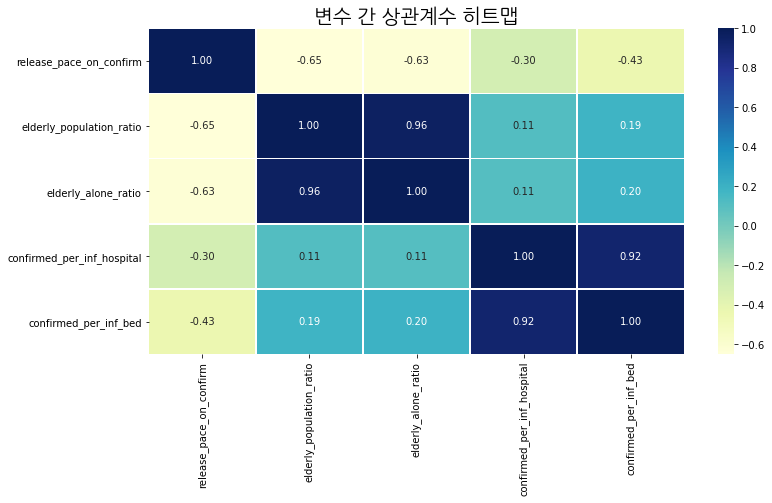

In [12]:
plt.figure(figsize=(12,6))
sns.heatmap(data=Region_df_new.corr(), annot=True, fmt = '.2f', linewidths=.5, cmap='YlGnBu')
plt.title('변수 간 상관계수 히트맵', fontproperties=font_prop_size20)
plt.show()

- 상관분석 결과, 완치자 증가세는 입력한 모든 변수와 음의 상관관계(반대로 움직임)를 보이고 있습니다. 이를 통해 아래의 두 가지 내용을 추론할 수 있습니다.
<br><br>
1. 각 지역별로 <span style="color:red">감염병 전담기관의 과부하 정도가 완치차 증가속도와 관계가 있는지</span> 확인할 필요가 있습니다. 
2. 지역별 인구구성이 완치자 증가속도와 관계가 있는지 확인할 필요가 있습니다. 그러나 단순히 주민등록상 인구구성이 완치 속도에 영향을 주었다는 주장은 설득력이 다소 떨어집니다. 대신, 실제 확진자 개인별 데이터를 활용해 <span style="color:red">확진자 집단의 연령별 인구구성이 완치자 증가속도에 영향을 주는지</span> 살펴보는 것은 의미가 있을 것입니다. → 그러나 본 내용은 데이터를 다각도로 검토한 결과, 단순히 연령대의 비중 만으로 

## 3-1. '완치자 증가속도'와 '의료기관의 과부하 정도'
- 먼저 각 지역별로 감염병 전담기관의 과부하 정도를 살펴보겠습니다. 앞서 히트맵에서는 '병상 당 누적확진자 수'가 완치자 증가속도와 음의 상관관계를 나타냈습니다.
- 보다 자세히 살펴보기 위해, '병상 당 누적확진자 수' 대비 '완치자 증가속도' 산점도를 시각화했습니다.

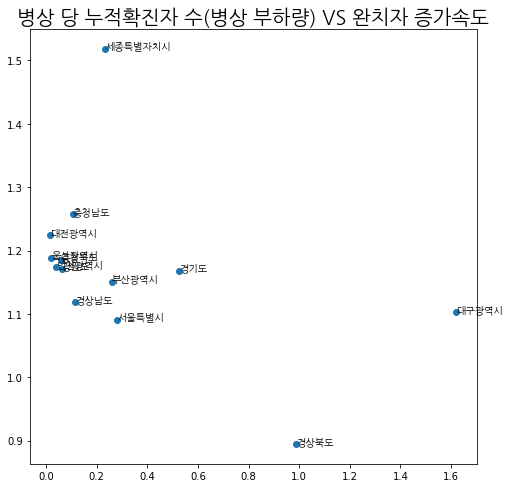

In [13]:
def scatter_col_vs_release(df, col='', col_title=None, xlim_list=None, ylim_list=None):
    if col_title is None:
        col_title = col
    
    plt.figure(figsize=(8, 8))
    plt.scatter( df[col], df.release_pace_on_confirm )
    plt.title(f'{col_title} VS 완치자 증가속도', fontproperties=font_prop_size20)
    for txt, x, y in zip(df.province_kor, df[col], df.release_pace_on_confirm ):
        plt.annotate(txt, (x, y), font_properties=font_prop_size10)
    
    if xlim_list is not None:
        plt.xlim(xlim_list)
    
    if ylim_list is not None:
        plt.ylim(ylim_list)
    pass

scatter_col_vs_release(Region_df_new, 'confirmed_per_inf_bed', '병상 당 누적확진자 수(병상 부하량)')

- 세종특별시라는 이상치가 존재하기는 하지만, 대체적으로 병상 당 누적확진자 수가 많을수록 상대적 완치자 증가속도가 떨어지는 현상을 확인할 수 있습니다.
- 결국, <span style="color:red">감염병 전문 의료 인프라가 잘 준비된 지역일수록 감염병에 효율적으로 대처한다</span>는 결론을 내릴 수 있습니다.